In [1]:
#Importamos el archivo desde amazon s3
import pandas as pd

df = pd.read_csv('aqui_ruta_a_bucket/df_fraude.csv')
df['feature_5']=df['feature_5'].astype(object)

In [2]:
df['target'].dtype

dtype('O')

In [3]:
#importamos de nuestra libreria el modulo de separacion
from preparimb.preparanding_data_set import separating_data_set

#dividimos la data con una de las funciones de nuestra libreria.
clase_separacion = separating_data_set.split_data_and_target()

[X, y] = clase_separacion.fit(df, 'target')

In [4]:
#cambiamos a numeros la variable target si esta es categorica, esto para utilizarla en la modelación de algoritmos.
from sklearn.preprocessing import LabelEncoder
import numpy as np
label_enc = LabelEncoder()
label_enc.fit(y.astype('str')) 
y_enc = np.array(label_enc.transform(y)) 
y_enc = pd.Series(y_enc, name='target')

## Modelación y evaluación de conjunto de datos originales

In [5]:
#por una actualización de la libreria sklearn debemos realizar esta tranformación ya que el modulo six 
#ya no es extensión de sklearn.
import six
import sys
sys.modules['sklearn.externals.six'] = six
import warnings
warnings.filterwarnings('ignore')
import time 
from sklearn.model_selection import train_test_split

#Separar en conjunto train y test
X_train, X_test, Y_train, Y_test =train_test_split(X, y_enc, test_size=0.5, random_state =123)

In [6]:
import sklearn.naive_bayes
import sklearn.svm._classes
import sklearn.linear_model._logistic
import sklearn.linear_model._perceptron
import lazypredict

In [7]:
from lazypredict.Supervised import LazyClassifier

#Seleccionamos solo algunos algoritmos
lazypredict.Supervised.CLASSIFIERS = [
                                    ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
                                    
                                    ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
                                    
                                    ('Perceptron', sklearn.linear_model._perceptron.Perceptron),
                                        
                                    ('SVC', sklearn.svm._classes.SVC),
    
]


In [8]:
classi = LazyClassifier(verbose=0, predictions=True)

# ajustar y entrenar el modelo  
start_time_1=time.time()
models_c, predictions_c = classi.fit(X_train, X_test, Y_train, Y_test)
end_time_1=time.time()

100%|██████████| 4/4 [00:25<00:00,  5.70s/it]


In [9]:
models_c

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,1.00,0.50,0.50,1.00,8.93
Perceptron,1.00,0.50,0.50,1.00,2.96
SVC,1.00,0.50,0.50,1.00,11.46
BernoulliNB,1.00,0.50,0.50,1.00,2.87


## Coeficiente de correlación Matthews

In [10]:
#Ahora calculamos las metricas que han sido validada para conjuntos desbalanceados
from pycm import *
MCC = list()

for i in list(predictions_c.columns):
    cm = ConfusionMatrix(list(Y_test), list(predictions_c[i]))
    MCC.append(list((cm.MCC).values())[0])

model_metrics_study = pd.DataFrame(
                {
                    "Model": list(predictions_c.columns),
                    "Matthews correlation coefficient": MCC
                }
            )

model_metrics_study 

,Model,Matthews correlation coefficient
0,BernoulliNB,-0.00
1,LogisticRegression,None
2,Perceptron,None
3,SVC,None


# Utilizando modulo de balanceo

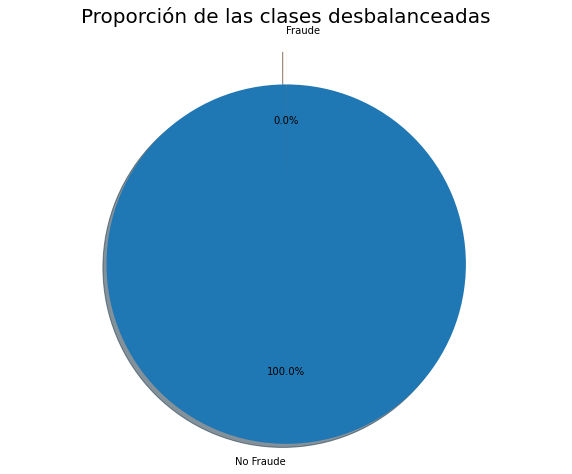

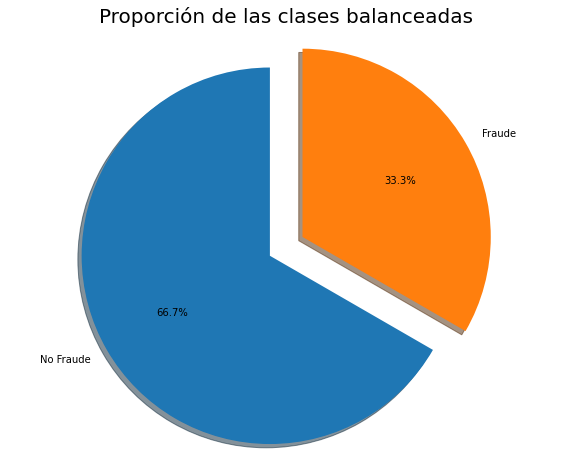

In [11]:
#Como esta claramente desbalanceado, utilizaremos el modulo para balancear.
from preparimb.preparanding_data_set import balancing_data_set

balancing_prueba = balancing_data_set.balance_target()
[x_balan, y_balan] = balancing_prueba.fit_balance(df, 'target')


In [12]:
y_balan.dtype

dtype('O')

In [13]:
#Para la modelacion debemos cambiar a numerico el target, esto para la metrica ROC AUC
label_enc = LabelEncoder()
label_enc.fit(y_balan.astype('str')) 
targetbalan = np.array(label_enc.transform(y_balan)) 
targetbalan = pd.Series(targetbalan, name='target')

## Modelación y evaluación de conjunto de datos balanceados

In [14]:
#Dividimos el conjunto balanceado en entrenamiento, prueba y validacion.
X_train_balan, X_test_balan, Y_train_balan, Y_test_balan =train_test_split(x_balan, targetbalan, test_size=0.5, random_state = 123)

In [15]:
lazypredict.Supervised.CLASSIFIERS

[('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
 ('Perceptron', sklearn.linear_model._perceptron.Perceptron),
 ('SVC', sklearn.svm._classes.SVC)]

In [16]:
classi_balan =LazyClassifier(verbose=0, predictions=True)

# ajustar y entrenar el modelo  
start_time_balan=time.time()
models_balan, predictions_balan= classi_balan.fit(X_train_balan, X_test_balan, Y_train_balan, Y_test_balan)
end_time_balan=time.time()

100%|██████████| 4/4 [6:21:30<00:00, 8492.95s/it] 


In [18]:
models_balan

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.91,0.89,0.89,0.91,22869.25
BernoulliNB,0.88,0.84,0.84,0.88,4.68
LogisticRegression,0.87,0.84,0.84,0.87,11.77
Perceptron,0.74,0.81,0.75,0.50,4.72


## Métricas estudiadas en datos balanceados

In [17]:
MCC_balan = list()

for i in list(predictions_balan.columns):
    cm = ConfusionMatrix(list(Y_test_balan), list(predictions_balan[i]))
    MCC_balan.append(list((cm.MCC).values())[0])
    
    
model_metrics_Study_balan = pd.DataFrame(
                {
                    "Model": list(predictions_balan.columns),
                    "Matthews correlation coefficient": MCC_balan
                }
            )

model_metrics_Study_balan

,Model,Matthews correlation coefficient
0,BernoulliNB,0.73
1,LogisticRegression,0.70
2,Perceptron,0.59
3,SVC,0.80
